## Design and Hedging of a Structured Product

### Experiment 02: Valuation

### Bates Model Overview

---

#### **What Is the Bates Model?**

The Bates model extends the Heston stochastic volatility model by incorporating **jumps** in the asset price. The risk-neutral dynamics are:

$$
\frac{dS_t}{S_{t^-}} = (r - \lambda \mathbb{E}[J - 1])\,dt + \sqrt{v_t}\,dW_t^S + (J - 1)\,dN_t
$$

$$
dv_t = \kappa(\theta - v_t)\,dt + \sigma\sqrt{v_t}\,dW_t^v
$$

**Where:**

- $S_t$: stock price  
- $v_t$: instantaneous variance  
- $r$: risk-free rate  
- $W_t^S, W_t^v$: correlated Brownian motions ($\rho$)  
- $N_t$: Poisson jump process with intensity $\lambda$  
- $J$: jump size, usually lognormally distributed

---

#### **Model Intuition**

| Component                     | Description                                          |
|------------------------------|------------------------------------------------------|
| Stochastic volatility (Heston) | Captures volatility clustering via $v_t$             |
| Jumps (Merton-type)          | Captures rare, large price moves                    |
| Correlation $\rho$           | Links volatility shocks with price shocks           |

---

#### **Why Use the Bates Model?**

- Captures **fat tails** and **skewness** in returns  
- Better fits **implied volatility surfaces**  
- Essential for pricing **exotic products** like Bonus Certificates

---

#### **Model Parameters**

| Parameter      | Meaning                                 |
|----------------|-----------------------------------------|
| $v_0$          | Initial variance                        |
| $\kappa$       | Mean reversion speed of variance        |
| $\theta$       | Long-run variance                       |
| $\sigma$       | Volatility of volatility                |
| $\rho$         | Correlation between asset and variance  |
| $\lambda$      | Jump intensity                          |
| $\mu_J$        | Mean of log jump size                   |
| $\sigma_J$     | Std. dev. of log jump size              |

---

#### **Characteristic Function $\phi(u)$**

$$
\phi(u) = \exp\left\{ iux + C(u,T) + D(u,T)v_0 + T\lambda \left(e^{iu\mu_J - \frac{1}{2}u^2\sigma_J^2} - 1\right) \right\}
$$

With:

$$
d = \sqrt{(\rho \sigma iu - \kappa)^2 + \sigma^2 (iu + u^2)}
$$

$$
g = \frac{\kappa - \rho \sigma iu - d}{\kappa - \rho \sigma iu + d}
$$

$$
C(u,T) = \frac{\kappa\theta}{\sigma^2}
\left[(\kappa - \rho \sigma iu - d)T - 2\log\left(\frac{1 - g e^{-dT}}{1 - g}\right)\right]
$$

$$
D(u,T) = \frac{\kappa - \rho \sigma iu - d}{\sigma^2} \cdot \left( \frac{1 - e^{-dT}}{1 - g e^{-dT}} \right)
$$


In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Valuation:
    def __init__(
        self,
        S0,
        r,
        T,
        v0,
        kappa,
        theta,
        sigma,
        rho,
        lamb,
        mu_j,
        sigma_j
    ):
        """
        Description
            Initialize Bates model parameters.

        Args:
            S0 (float): Spot price.
            r (float): Risk-free rate.
            T (float): Time to maturity (in years).
            v0 (float): Initial variance.
            kappa (float): Mean reversion rate.
            theta (float): Long-run variance.
            sigma (float): Volatility of volatility.
            rho (float): Correlation between stock and variance.
            lamb (float): Jump intensity (λ).
            mu_j (float): Mean of log jump size.
            sigma_j (float): Std. dev. of log jump size.
        """
        self.S0 = S0
        self.r = r
        self.T = T
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.lamb = lamb
        self.mu_j = mu_j
        self.sigma_j = sigma_j

    def bs_characteristic_function(self, u, sigma):
        """
        Black Scholes Characteristic function for Sanity Check.

        Args:
            u (np.ndarray or float): Fourier variable.
            sigma (float): Representative volatility.

        Returns:
            float: Black Scholes Characteristic function value.
        """
        i = 1j
        return np.exp(i * u * np.log(self.S0) + 
                      (i * u * (self.r - 0.5 * sigma ** 2) - 
                       0.5 * u ** 2 * sigma ** 2) * self.T)

    def bates_characteristic_function(self, u):
        """
        Description
            Characteristic function φ(u) of log(S_T) under the Bates model.

        Args:
            u (np.ndarray or float): Fourier variable.

        Returns:
            np.ndarray or float: Characteristic function value at u.
        """
        i = 1j
        x = np.log(self.S0)

        d = np.sqrt(
            (self.rho * self.sigma * i * u - self.kappa) ** 2
            + self.sigma ** 2 * (i * u + u ** 2)
        )

        g = (self.kappa - self.rho * self.sigma * i * u - d) / (
            self.kappa - self.rho * self.sigma * i * u + d
        )

        C = (
            self.kappa * self.theta / self.sigma ** 2
            * ((self.kappa - self.rho * self.sigma * i * u - d) * self.T
               - 2 * np.log((1 - g * np.exp(-d * self.T)) / (1 - g)))
        )

        D = (
            (self.kappa - self.rho * self.sigma * i * u - d)
            / self.sigma ** 2
            * ((1 - np.exp(-d * self.T)) / (1 - g * np.exp(-d * self.T)))
        )

        jump_term = self.lamb * self.T * (
            np.exp(i * u * self.mu_j - 0.5 * self.sigma_j ** 2 * u ** 2) - 1
        )

        return np.exp(i * u * x + C + D * self.v0 + jump_term)

    def carr_madan_price(self, alpha=1.5, N=4096, eta=0.25):
        """
        Description
            Compute option prices using Carr-Madan method with FFT.

        Args:
            alpha (float): Dampening factor.
            N (int): Number of FFT points (must be power of 2).
            eta (float): Integration grid spacing.

        Returns:
            tuple: (strikes array, call prices array)
        """
        i = 1j
        lamb = 2 * np.pi / (N * eta)
        b = N * lamb / 2

        u = np.arange(N) * eta
        ku = -b + lamb * np.arange(N)

        phi = self.bates_characteristic_function(u - (alpha + 1) * i)
        # Black Scholes for Sanity Check.
        #phi = self.bs_characteristic_function(u - (alpha + 1) * i, sigma=0.25)
        psi = (
            np.exp(-self.r * self.T)
            * phi
            / (alpha ** 2 + alpha - u ** 2 + i * (2 * alpha + 1) * u)
        )

        # Construct Simpson's weights
        simpson_weights = np.ones(N)
        simpson_weights[1:N-1:2] = 4
        simpson_weights[2:N-1:2] = 2
        simpson_weights *= eta / 3

        # Apply Simpson's weights to the input
        fft_input = np.exp(i * b * u) * psi * simpson_weights
        
        fft_output = fft(fft_input).real

        call_prices = (np.exp(-alpha * ku) / np.pi) * fft_output
        strikes = np.exp(ku)

        return strikes, call_prices

    def interpolate_call_price(self, K_target):
        """
        Description
            Interpolate the call price at a specific strike using Carr-Madan FFT.

        Args:
            K_target (float): Strike price.

        Returns:
            float: Interpolated call price.
        """
        strikes, prices = self.carr_madan_price()
        try:
            interpolator = interp1d(
                strikes,
                prices,
                kind="cubic",
                bounds_error=True  # prevent silent extrapolation
            )
            return interpolator(K_target)

        except ValueError as e:
            print(f"[Warning] Strike {K_target} is outside interpolation range.")
            raise e

In [3]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


In [4]:
val = Valuation(
    S0=S0,           # loaded from CSV
    r=0.04,          # risk-free rate
    T=0.25,          # 3 months to maturity
    v0=0.04,         # initial variance
    kappa=2.0,       # mean reversion speed
    theta=0.04,      # long-term variance
    sigma=0.3,       # vol of vol
    rho=-0.5,        # correlation
    lamb=0.2,        # jump intensity
    mu_j=-0.1,       # mean jump size
    sigma_j=0.2      # jump std dev
)

In [5]:
call_price_950 = val.interpolate_call_price(K_target=950)
print(f"Call price at K=950: {call_price_950:.4f}")

Call price at K=950: 39.7669


#### Let's check call price from black scholes for sanity check

In [6]:
def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    """
    This function returns the Call or Put Price using the
    Black-Scholes Formula.

    Args:
        K (float): Strike Price, the price at which the option
                    can be exercised.
        T (float): Time to maturity, the time when the option
                    may be exercised.
        S_0 (float): Initial price of the underlying stock.
        r_f (float): Risk-Free rate, government bond return
                    rates etc.
        sigma (float): Volatility, of the market, assumed
                    to be constant in the Black-Scholes
                    Model.
        dividend_yield (float): No Idea, like how much dividiend is paid out?

    Returns:
        C (float): Call Price
        P (float): Put Price
    """
    # d_1 used to calculate N_d1, the z-score (fed into std normal later) for
    # expected log return of the asset being above the strike at time T,
    # under risk neutral dynamics.
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

    # d_2 used to calculate N_d2, the z-scroe for the actual probability that
    # the model will expire in the money, under risk-neutral measure.
    d_2 = d_1 - (sigma * np.sqrt(T))

    # N_d1 and N_d2 are the cumulative probability of d_1 and d_2 from a Std. Normal dist.
    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = ( (S_0 * np.exp(-dividend_yield * T) * N_d1) - 
         (K * np.exp(-r_f * T) * N_d2) )
    
    # Put price derived with Put-Call Parity
    P = ( (np.exp(-r_f * T) * K) - (np.exp(-dividend_yield * T) * S_0) + C )

    return C,P

In [7]:
# Inputs
K = 950                  # Strike price
T = 0.25                 # 3 months
S0 = S0             # Spot price from your CSV
r = 0.04                 # Annual risk-free rate
sigma = 0.25             # Assume constant vol for now
q = 0.008                # Dividend yield (e.g. 0.8% for Costco, adjust if needed)

# Call the function
call_price, put_price = black_scholes_price(K, T, S0, r, sigma, q)

print(f"Black-Scholes Call Price at K={K}: {call_price:.2f} USD")
print(f"Black-Scholes Put Price at K={K}: {put_price:.2f} USD")


Black-Scholes Call Price at K=950: 53.38 USD
Black-Scholes Put Price at K=950: 41.44 USD


#### Let's do some calibration with clen call and put data from 01 April 2025

In [8]:
class Calibration(Valuation):
    def __init__(self, *args, **kwargs):
        """
        Inherits all attributes from Valuation.
        """
        super().__init__(*args, **kwargs)

    def calibrate_to_market(self, clean_calls_df, initial_guess, bounds):
        """
        Description
            Calibrate Bates model parameters to market call prices.

        Args:
            clean_calls_df (pd.DataFrame): DataFrame with 'strike' and 'mid' columns.
            initial_guess (list): Initial parameter guess in order:
                [v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j]
            bounds (list of tuples): Bounds for each parameter.

        Returns:
            dict: Optimized parameters, loss value, and success flag.
        """
        strikes = clean_calls_df["strike"].values
        market_prices = clean_calls_df["mid"].values

        def objective(params):
            self.v0, self.kappa, self.theta, self.sigma, self.rho, self.lamb, self.mu_j, self.sigma_j = params
            model_prices = []
            for K in strikes:
                try:
                    model_price = self.interpolate_call_price(K)
                except Exception:
                    model_price = np.nan
                model_prices.append(model_price)

            model_prices = np.array(model_prices)
            mask = ~np.isnan(model_prices)
            error = model_prices[mask] - market_prices[mask]
            return np.sum(error ** 2)

        result = minimize(
            objective,
            x0=initial_guess,
            bounds=bounds,
            method='L-BFGS-B'
        )

        # Update instance if successful
        if result.success:
            self.v0, self.kappa, self.theta, self.sigma, self.rho, self.lamb, self.mu_j, self.sigma_j = result.x

        return {
            "optimized_params": result.x,
            "loss": result.fun,
            "success": result.success,
            "message": result.message
        }
    
    def plot_calibrated_vs_market(self, clean_calls_df, full_grid=False, num_strikes=100):
        """
        Plot model-calibrated call prices vs market prices.
    
        Args:
            clean_calls_df (pd.DataFrame): Market data with 'strike' and 'mid' columns.
            full_grid (bool): If True, plot model over a full strike range [0.5*S0, 1.5*S0].
            num_strikes (int): Number of strike points in the full grid.
        """
        market_strikes = clean_calls_df["strike"].values
        market_prices = clean_calls_df["mid"].values

        # Plotting base: market points
        plt.figure(figsize=(10, 6))
        plt.plot(market_strikes, market_prices, 'o', label="Market", color="steelblue", alpha=0.7)

        if full_grid:
            # Generate a dense grid of strikes
            strike_grid = np.linspace(0.5 * self.S0, 1.5 * self.S0, num_strikes)
            model_prices = []
            for K in strike_grid:
                try:
                    price = self.interpolate_call_price(K)
                except Exception:
                    price = np.nan
                model_prices.append(price)
            plt.plot(strike_grid, model_prices, 'r-', label="Bates (Calibrated)", lw=2)
        else:
            # Just interpolate at the available strike points
            model_prices = []
            for K in market_strikes:
                try:
                    price = self.interpolate_call_price(K)
                except Exception:
                    price = np.nan
                model_prices.append(price)
            plt.plot(market_strikes, model_prices, 'r*', label="Bates (Calibrated)", markersize=6)

        plt.xlabel("Strike Price (K)")
        plt.ylabel("Call Price")
        plt.title("Bates Model Calibration: Market vs Calibrated Prices")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_residuals(self, clean_calls_df):
        """
        Plot residuals between model-calibrated call prices and market prices.

        Args:
            clean_calls_df (pd.DataFrame): DataFrame with 'strike' and 'mid' columns.
        """
        import matplotlib.pyplot as plt

        strikes = clean_calls_df["strike"].values
        market_prices = clean_calls_df["mid"].values
        model_prices = []

        for K in strikes:
            try:
                model_price = self.interpolate_call_price(K)
            except Exception:
                model_price = np.nan
            model_prices.append(model_price)

        model_prices = np.array(model_prices)
        residuals = model_prices - market_prices

        plt.figure(figsize=(10, 4))
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
        plt.scatter(strikes, residuals, color='crimson', label='Residuals')
        plt.xlabel("Strike Price (K)")
        plt.ylabel("Residual (Model - Market)")
        plt.title("Bates Model Calibration Residuals")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [9]:
calls_df  = pd.read_csv('../data/calls_data_cost_2025-04-01_final.csv')
puts_df = pd.read_csv('../data/puts_data_cost_2025-04-01_final.csv')
print("Shape calls_df:",calls_df.shape)
print("Shape puts_df:",puts_df.shape)

Shape calls_df: (180, 18)
Shape puts_df: (169, 18)


In [10]:
clean_calls_df = calls_df[calls_df['is_clean']]
clean_puts_df = puts_df[puts_df['is_clean']]
print("Shape clean_calls_df:",clean_calls_df.shape)
print("Shape clean_puts_df:",clean_puts_df.shape)

Shape clean_calls_df: (16, 18)
Shape clean_puts_df: (22, 18)


In [11]:
# === Initial parameter guesses for Bates model ===

# Volatility dynamics
v0_init       = 0.04   # Initial variance
kappa_init    = 2.0    # Speed of mean reversion
theta_init    = 0.04   # Long-run variance
sigma_init    = 0.3    # Volatility of volatility
rho_init      = -0.5   # Correlation (negative, as typically observed)

# Jump component
lambda_init   = 0.2    # Jump intensity (avg. # of jumps per year)
mu_j_init     = -0.1   # Mean of jump size (in log-space)
sigma_j_init  = 0.2    # Volatility of jump size

In [12]:
# Group into a list
initial_guess = [
    v0_init,
    kappa_init,
    theta_init,
    sigma_init,
    rho_init,
    lambda_init,
    mu_j_init,
    sigma_j_init
]

# Parameter bounds for optimizer
bounds = [
    (1e-4, 1.0),    # v0
    (0.1, 5.0),     # kappa
    (1e-4, 1.0),    # theta
    (0.05, 1.0),    # sigma
    (-0.999, 0.0),   # rho
    (0.0, 1.0),     # lambda
    (-0.5, 0.1),    # mu_j
    (1e-4, 1.0)     # sigma_j
]


In [13]:
calibrator = Calibration(S0, r, T, *initial_guess)

result = calibrator.calibrate_to_market(
    clean_calls_df=clean_calls_df,
    initial_guess=initial_guess,
    bounds=bounds
)

print("Success:", result["success"])
print("Final loss:", result["loss"])
print("Optimized θ:", result["optimized_params"])

Success: True
Final loss: 9407.59158591326
Optimized θ: [ 0.14196912  1.49831721  0.15241774  0.72587256 -0.9926844   0.07850871
  0.09172199  0.17448892]


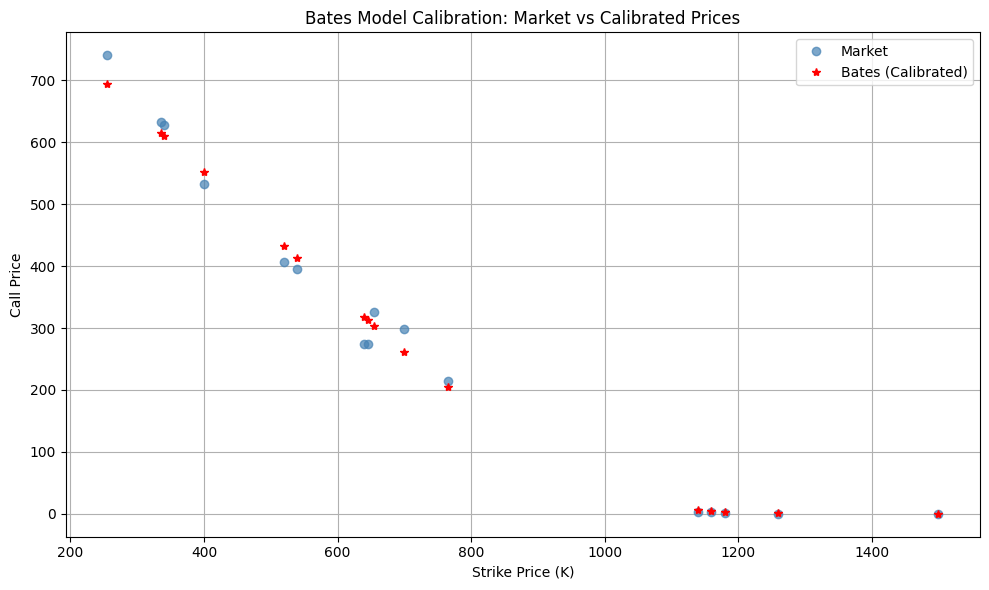

In [14]:
calibrator.plot_calibrated_vs_market(clean_calls_df)

In [15]:
print(clean_calls_df["strike"].min(), clean_calls_df["strike"].max())

255.0 1500.0


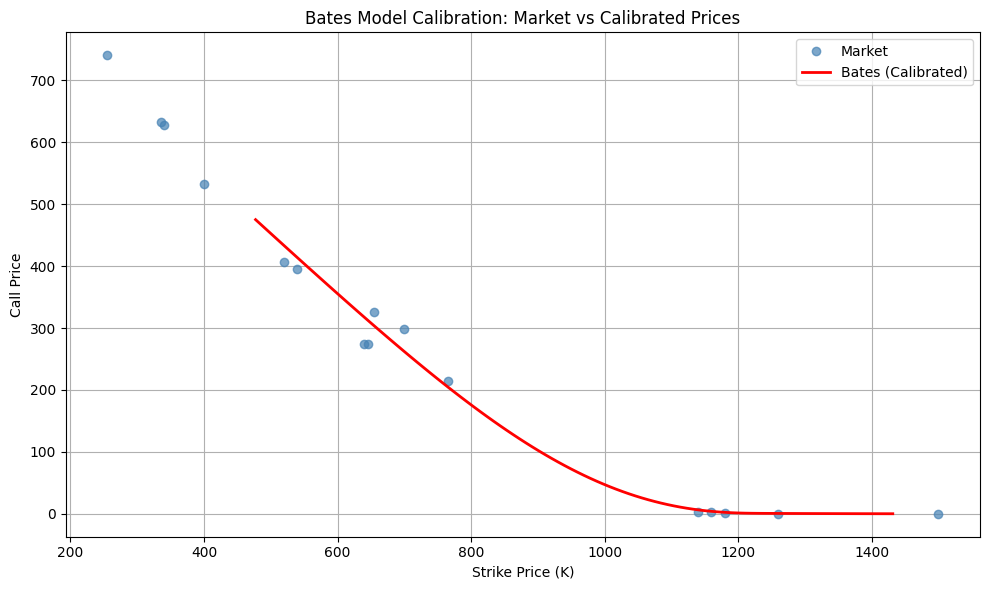

In [16]:
calibrator.plot_calibrated_vs_market(clean_calls_df, full_grid=True)

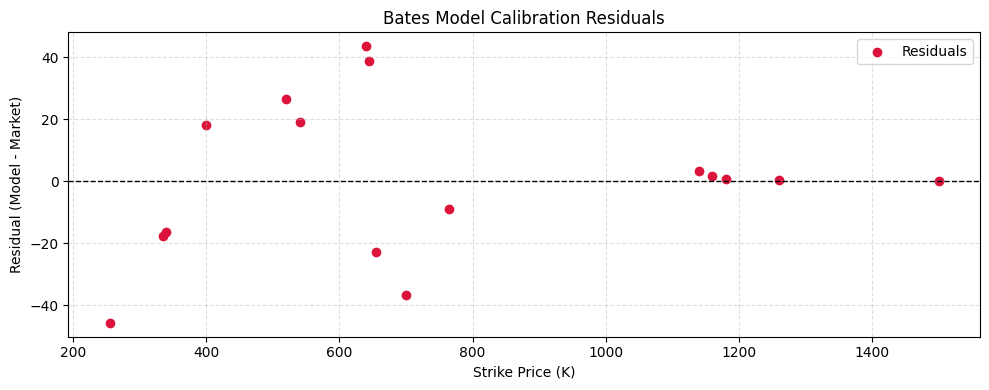

In [17]:
calibrator.plot_residuals(clean_calls_df)

### Let's do exotic product - Bonus Certificate pricing with Monte Carlo Methods

In [18]:
class MonteCarloExoticPricer(Calibration):
    def __init__(self, *args, **kwargs):
        """
        Inherits parameters from Calibration (which inherits from Valuation).
        """
        super().__init__(*args, **kwargs)

    def simulate_paths(self, N_paths=100000, N_steps=252, seed=42, vol_truncation="max"):
        """
        Simulate asset price paths under the Bates model.

        Args:
            N_paths (int): Number of Monte Carlo paths.
            N_steps (int): Number of time steps.
            seed (int): Random seed.
            vol_truncation (str): 'max' or 'abs' method for ensuring non-negative variance.

        Returns:
            np.ndarray: Simulated stock paths of shape (N_paths, N_steps + 1).
        """

        np.random.seed(seed)
        dt = self.T / N_steps

        S_paths = np.zeros((N_paths, N_steps + 1))
        v_paths = np.zeros((N_paths, N_steps + 1))

        S_paths[:, 0] = self.S0
        v_paths[:, 0] = self.v0

        EJ = np.exp(self.mu_j + 0.5 * self.sigma_j ** 2) - 1

        for t in range(1, N_steps + 1):
            v_prev = v_paths[:, t - 1]
            S_prev = S_paths[:, t - 1]

            Z1 = np.random.normal(size=N_paths)
            Z2 = np.random.normal(size=N_paths)
            dW_v = Z1 * np.sqrt(dt)
            dW_s = (self.rho * Z1 + np.sqrt(1 - self.rho ** 2) * Z2) * np.sqrt(dt)

            # Variance update (Euler)
            v_candidate = v_prev + self.kappa * (self.theta - v_prev) * dt + \
                        self.sigma * np.sqrt(np.maximum(v_prev, 0)) * dW_v

            if vol_truncation == "abs":
                v_new = np.abs(v_candidate)
            elif vol_truncation == "max":
                v_new = np.maximum(v_candidate, 0)
            else:
                raise ValueError("vol_truncation must be 'abs' or 'max'")

            v_paths[:, t] = v_new

            # Jump component
            N_jump = np.random.poisson(self.lamb * dt, size=N_paths)
            J = np.random.lognormal(self.mu_j, self.sigma_j, size=N_paths)

            # Log return
            log_return = (
                (self.r - self.lamb * EJ - 0.5 * v_prev) * dt +
                np.sqrt(np.maximum(v_prev, 0)) * dW_s +
                N_jump * np.log(J)
            )

            S_paths[:, t] = S_prev * np.exp(log_return)

        return S_paths
    
    def plot_path_comparison(self, paths_abs, paths_max, n_paths_plot=50):
        """
        Compare simulated stock price paths under two volatility truncation schemes.

        Args:
            paths_abs (np.ndarray): Paths using abs truncation.
            paths_max (np.ndarray): Paths using max truncation.
            n_paths_plot (int): Number of paths to show for each.
        """
        T = paths_abs.shape[1] - 1
        time = np.linspace(0, 1, T + 1)

        plt.figure(figsize=(14, 5))

        # Left: abs
        plt.subplot(1, 2, 1)
        plt.plot(time, paths_abs[:n_paths_plot].T, lw=0.5, alpha=0.7)
        plt.title("Simulated Paths (abs truncation)")
        plt.xlabel("Time (T normalized)")
        plt.ylabel("Stock Price")
        plt.grid(True)

        # Right: max
        plt.subplot(1, 2, 2)
        plt.plot(time, paths_max[:n_paths_plot].T, lw=0.5, alpha=0.7)
        plt.title("Simulated Paths (max truncation)")
        plt.xlabel("Time (T normalized)")
        plt.grid(True)

        plt.tight_layout()
        plt.show()


    def price_bonus_certificate(self, B, H, N_paths=100000, N_steps=252, seed=42, vol_truncation="max"):
        """
        Price the Bonus Certificate via Monte Carlo simulation.

        Args:
            B (float): Bonus level.
            H (float): Barrier level (lower barrier).
            N_paths (int): Number of simulation paths.
            N_steps (int): Number of time steps per path.
            seed (int): Random seed for reproducibility.
            vol_truncation (str): Volatility truncation method ("max" or "abs").

        Returns:
            float: Monte Carlo price (discounted expected payoff).
        """
        paths = self.simulate_paths(N_paths=N_paths, N_steps=N_steps, seed=seed, vol_truncation=vol_truncation)
        S_T = paths[:, -1]                  # Final prices
        barrier_hit = (paths <= H).any(axis=1)  # Barrier breach across time

        payoff = np.where(
            barrier_hit,
            S_T,                     # If barrier hit → get S_T
            np.where(S_T >= B, S_T, B)  # Else: if S_T >= B → S_T, else → B
        )

        return np.exp(-self.r * self.T) * payoff.mean()

    def evaluate_bonus_certificate_payoffs(self, paths, B, H):
        """
        Compute payoff per path for the Bonus Certificate.

        Args:
            paths (np.ndarray): Simulated stock price paths (N_paths x N_steps + 1).
            B (float): Bonus level.
            H (float): Barrier level.

        Returns:
            np.ndarray: Payoffs for each path.
        """
        S_T = paths[:, -1]
        barrier_hit = (paths <= H).any(axis=1)

        payoff = np.where(
            barrier_hit,
            S_T,
            np.where(S_T >= B, S_T, B)
        )

        return payoff

        

In [19]:
S0 = S0
r = 0.04
T = 0.25

# Unpack optimized Bates parameters
v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j = result["optimized_params"]

# Create pricer with calibrated model
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

paths_abs = pricer.simulate_paths(vol_truncation="abs")
paths_max = pricer.simulate_paths(vol_truncation="max")

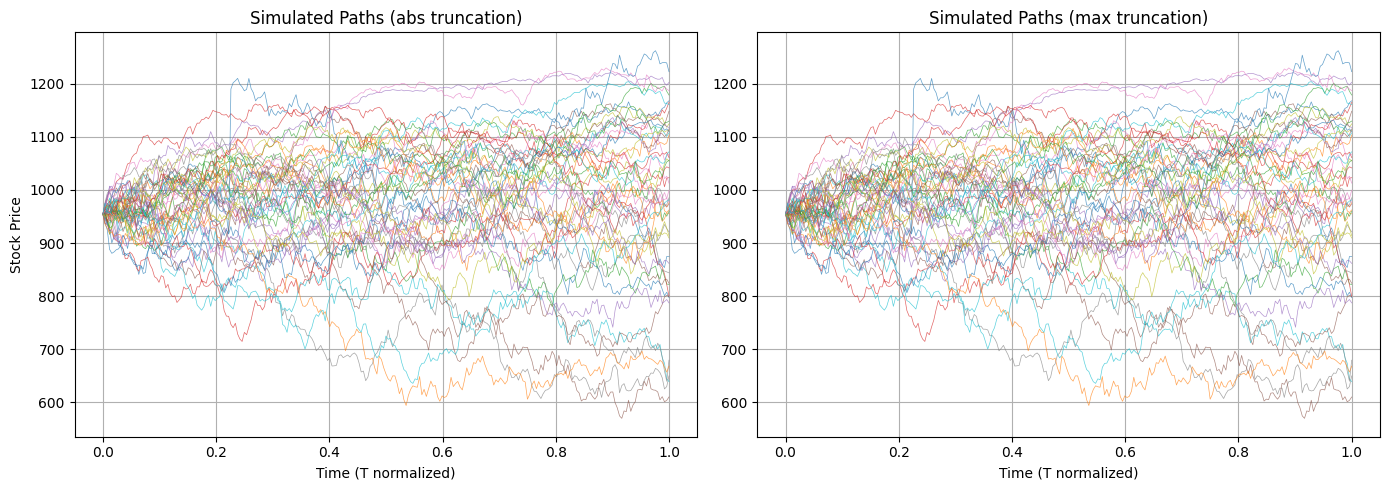

In [20]:
pricer.plot_path_comparison(paths_abs, paths_max)

### Volatility Truncation Method: `max(0, ·)`

To ensure non-negative variance in the Bates model simulation, we use **Euler discretization** with a **"max truncation"** scheme:

\[
v_{t+1} = \max(0, v_t + \text{Euler increment})
\]

#### Justification:
- Respects the financial constraint that **variance cannot be negative**
- Prevents invalid square roots and resulting numerical instability
- Aligns with the **Cox-Ingersoll-Ross (CIR)** process structure in the Heston and Bates models
- Common practice in Monte Carlo option pricing literature (e.g., Andersen & Andreasen)

This method is simple, stable, and appropriate for structured product pricing where high-frequency volatility behavior is not the primary focus.


In [21]:
# Bonus certificate pricing, chosen (B=1000, H=750)
bonus_level = 1000
barrier_level = 750

price_bc = pricer.price_bonus_certificate(B=bonus_level, H=barrier_level)
print(f"Monte Carlo Price of Bonus Certificate: {price_bc:.2f} USD")

Monte Carlo Price of Bonus Certificate: 980.39 USD


### Bonus Level and Barrier Grid Search

To design a Bonus Certificate that is attractive to investors and includes a margin for the issuing bank, we perform a grid search over:

- **Bonus levels \( B \)**: candidate final payouts if the barrier is not breached
- **Barrier levels \( H \)**: the lower bound that determines whether the bonus is paid or not
- **Maturity \( T = 0.25 \)** is fixed as a 3-month horizon

We compute the Monte Carlo price for each \( (B, H) \) combination using our calibrated Bates model, with 252 time steps and 100,000 simulated paths. The resulting table helps us select a structure that is both:

- **Attractive to the investor** (price near or slightly below \( B \))
- **Profitable for the bank** (offered at a higher market price than true model value)


In [22]:
"""
bonus_levels = [900, 925, 950, 975, 1000]
barrier_levels = [650, 700, 750, 800]

pricing_grid = {}

for B in bonus_levels:
    pricing_grid[B] = {}
    for H in barrier_levels:
        price = pricer.price_bonus_certificate(
            B=B, H=H,
            N_paths=100000,
            N_steps=252,
            vol_truncation="max"
        )
        pricing_grid[B][H] = price
        print(f"Price for B={B}, H={H}: {price:.2f}")
"""

'\nbonus_levels = [900, 925, 950, 975, 1000]\nbarrier_levels = [650, 700, 750, 800]\n\npricing_grid = {}\n\nfor B in bonus_levels:\n    pricing_grid[B] = {}\n    for H in barrier_levels:\n        price = pricer.price_bonus_certificate(\n            B=B, H=H,\n            N_paths=100000,\n            N_steps=252,\n            vol_truncation="max"\n        )\n        pricing_grid[B][H] = price\n        print(f"Price for B={B}, H={H}: {price:.2f}")\n'

Fair Value of Bonus Certificate: 980.39 USD


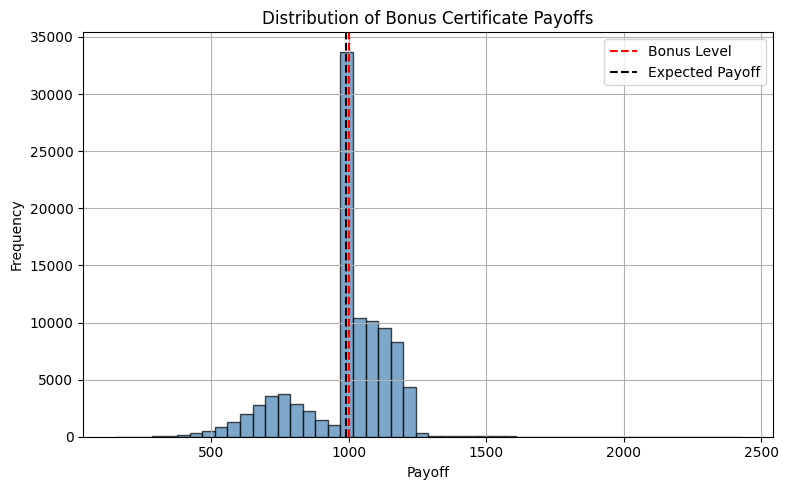

In [23]:
# Simulate paths using "max" truncation
paths = pricer.simulate_paths(N_paths=100000, N_steps=252, vol_truncation="max")

# Compute per-path payoffs
payoffs = pricer.evaluate_bonus_certificate_payoffs(paths, B=1000, H=750)

# Discounted price (Monte Carlo value)
discounted_price = np.exp(-r * T) * payoffs.mean()
print(f"Fair Value of Bonus Certificate: {discounted_price:.2f} USD")

# Histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x=1000, color="red", linestyle="--", label="Bonus Level")
plt.axvline(x=payoffs.mean(), color="black", linestyle="--", label="Expected Payoff")
plt.title("Distribution of Bonus Certificate Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
sell_price = 1000  # offered to investor
cost_price = discounted_price
margin = sell_price - cost_price
print(f"Bank's expected margin: {margin:.2f} USD")

Bank's expected margin: 19.61 USD


In [25]:
import json

# Gather all pricer state into a dictionary
pricer_config = {
    "S0": pricer.S0,
    "r": pricer.r,
    "T": pricer.T,
    "params": {
        "v0": pricer.v0,
        "kappa": pricer.kappa,
        "theta": pricer.theta,
        "sigma": pricer.sigma,
        "rho": pricer.rho,
        "lamb": pricer.lamb,
        "mu_j": pricer.mu_j,
        "sigma_j": pricer.sigma_j
    }
}

# Save to JSON
with open("calibrated_pricer.json", "w") as f:
    json.dump(pricer_config, f, indent=4)